<h2>Data Challenge</h2>
<h4>Herbert Xuebin Huang

NYC MTA Turnstile Usage Dataset
dataset is as followed:
http://web.mta.info/developers/turnstile.html

In order to improve time efficiency, this project uses intensively the mapping functions. It took less than 5 minutes to preprocess 'ALL' the data for 2013!!!
<br><br>
"The expected time for you to run all this code from top to bottom will be 5-8 minutes"
<br>
<br>This project consists four parts:
<br>Step 0. Assumption & Definition
<br>Step 1. Basic Functions & Preparation
<br>Step 2. Data Analysis
<br>Step 3. Data Visualization

<h2>Step 0. Assumption & Definition</h2>
<br>1. When there is no record for a certain turnstile, I will assume the number of entries & exists is zero on that day.
<br>
<br>2. There are some unexpected 'errors' with the cumulative count of some turnstiles. When calculating the entries & exits count for a turnstile on one day, if the number is beyond the range of 0 and 50,000, we will remove the last record until it falls into this range. 
<br>For example: (In this project, for the following case, the number of entries will be: 002019594 - 002019594 = 0; and the number of exits will be: 000200679 - 000200663 = 16, namely, the last record will be removed)
<br>
<br>('01-05-13', '07:00:00', 'REGULAR', '002019594', '000200663'),
<br>('01-05-13', '08:25:22', 'DOOR OPEN', '002019594', '000200673'),
<br>('01-05-13', '08:42:45', 'LOGON', '002019594', '000200673'),
<br>('01-05-13', '08:46:03', 'LGF-MAN', '002019594', '000200673'),
<br>('01-05-13', '08:46:31', 'LOGON', '002019594', '000200673'),
<br>('01-05-13', '09:24:40', 'DOOR OPEN', '002019594', '000200679'),
<br>('01-05-13', '09:42:29', 'DOOR CLOSE', '000000000', '000000002'),
<br>
<br>3. For the row counts in the data visualization part. Since each row in the text file contains multiple dates, it might not be meaningful enough to calculate the row counts in this way. Therefore, I would prefer consider each record as a seperate row. <br>For example: (In the data file, the following is one row, but in this project, I will treat them as eight rows.)
<br>
<br>A002,R051,02-00-00,<br>07-27-13,00:00:00,REGULAR,004209603,001443585,<br>07-27-13,04:00:00,REGULAR,004209643,001443593,<br>07-27-13,08:00:00,REGULAR,004209663,001443616,<br>07-27-13,12:00:00,REGULAR,004209741,001443687,<br>07-27-13,16:00:00,REGULAR,004210004,001443740,<br>07-27-13,20:00:00,REGULAR,004210276,001443777,<br>07-28-13,00:00:00,REGULAR,004210432,001443801,<br>07-28-13,04:00:00,REGULAR,004210472,001443805 

<h2>Step 1. Basic Functions & Preparation

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import itertools
from functools import reduce
import pandas as pd
import xlrd
from datetime import datetime
import datetime as dt
import time
import matplotlib.pyplot as plt
import numpy as np
import pylab

In [2]:
#Connect to url and get the names list for the data files
url = "http://web.mta.info/developers/turnstile.html"
response=requests.get(url)
raw_data = BeautifulSoup(response.content, 'lxml')
data_list = raw_data.find_all('div', {'class': "span-84 last"})
for tag in data_list:
    name_list = tag.find_all('a')

In [3]:
#We are only interested in the newest data and those in 2013
href_today = name_list[0].get('href')

href_2013 = list(filter(lambda x: x[-10:-8]=='13', map(lambda x: x.get('href'), name_list)))

href_2013 += list(filter(lambda x: x[-10:-4]=='140104', map(lambda x: x.get('href'), name_list)))

href_2013 = sorted(href_2013)

In [4]:
date_list = sorted(list(map(lambda x: datetime.strptime(x[-10:-4], '%y%m%d'), href_2013)))

In [5]:
date_2013 = [datetime(2013,1,1) + dt.timedelta(i) for i in range(365)]

In [6]:
date_2013_Q1 = date_2013[0:90]
date_2013_Q2 = date_2013[90:181]
date_2013_Q3 = date_2013[181:273]
date_2013_Q4 = date_2013[273:]

In [7]:
def formatting(a):
    b=list()
    for i in range(int(0.5*len(a))):
        b.append(tuple((a[2*i]+a[2*i+1]).split(',')[0:5]))
    return b

In [8]:
def diff(a):
    try:
        n = len(a)-1
        ans = a[n] - a[0]    
        while ans<0 or ans>50000:
            n -= 1
            ans = a[n] - a[0]
    except: 
        ans = 0
    return ans

In [9]:
def data_counting(my_data, date):
    str_date = datetime.strftime(date, '%m-%d-%y')
    my_filter_data = list(map(lambda x: (x[0], \
                        list(filter(lambda y: y[0]==str_date, x[1]))), my_data))

    my_counting_data = list(map(lambda x: (x[0], list(map(lambda y: int(y[3]), x[1])), \
                        list(map(lambda y: int(y[4]), x[1]))), my_filter_data))

    my_count = list(map(lambda x: (x[0], diff(x[1])+diff(x[2]), len(x[1])), my_counting_data))

    return my_count

def data_generating(my_href):
    tic = time.clock()
    my_date = datetime.strptime(my_href[-10:-4], '%y%m%d')    
    href_date_list = list()
    if my_date==date_list[0]:
        date_to_add = datetime(2012, 12, 29, 0, 0)
    else:
        date_to_add = date_list[date_list.index(my_date)-1]
    while date_to_add < my_date:
        href_date_list.append(date_to_add)
        date_to_add += dt.timedelta(1)
    
    my_url = 'http://web.mta.info/developers/' + my_href
    response = requests.get(my_url)
    my_raw_data = BeautifulSoup(response.content, 'lxml')
    data_1 = [x.strip() for x in my_raw_data.getText().split('\n')]

    #Remove the empty element(the last one)
    try: data_1.remove('')
    except: pass
    
    data_2 = list(map(lambda x: (x[0], x[1:]), map(lambda x: re.split(r"(\w+-\w+-\w+,\w+:\w+:\w+)",x), data_1)))
    data_3 = list(map(lambda x: (tuple(x[0].split(',')[0:3]),formatting(x[1])) ,data_2))
    
    data_4 = list(map(lambda x: (x[0], list(itertools.chain(*map(lambda y: y[1], x[1])))), \
         itertools.groupby(sorted(data_3, key=lambda x: x[0]), lambda x: x[0])))  
   
    my_count = list(map(lambda date: (date, data_counting(data_4, date)), href_date_list))
    toc = time.clock()
    #print('Time elapse:', toc-tic)
    return my_count

<h3> Step 1.1. Generate all the data for 2013 (takes around 3-5 minutes)

In [10]:
my_2013_raw_data = list()
for i in href_2013:
    my_2013_raw_data += data_generating(i)

In [11]:
my_2013_data = list(filter(lambda x: x[0] in date_2013, my_2013_raw_data))

<h3>Step 1.2. Generate the dictionary to convert units to stations

In [12]:
#Overall there are 4619 turnstiles in 2013
unique_turnstile = list(map(lambda date: list(map(lambda x: x[0], date[1])), my_2013_data))
unique_turnstile = set(itertools.chain(*unique_turnstile))
print(len(unique_turnstile))

#Overall there are 736 units in 2013
unique_unit = set(list(map(lambda x: x[0:2], unique_turnstile)))
print(len(unique_unit))

4619
736


In [13]:
station_df = pd.read_excel('http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls')

#Create a dictionary to convert turnstiles to their coresponding stations
station_list = list(station_df.apply(lambda x: {(x[1],x[0]): x[2]}, axis=1))
station_dic = dict()
for i in station_list:
    station_dic.update(i)

In [14]:
#There are ten units missing in the Excel station dictionary file
#We need to manually search them
for i in unique_unit:
    if i not in station_dic:
        print(i)

('R101', 'R001')
('R612', 'R057')
('A081', 'R028')
('N330', 'R202')
('A082', 'R028')
('LGA02', 'R538')
('A049', 'R088')
('A077', 'R028')
('N098', 'R028')
('R169', 'R168')


In [15]:
#Fill out the missing values
extension_dic=dict()

extension_dic[('A077', 'R028')] = 'FULTON ST'
extension_dic[('A081', 'R028')] = 'FULTON ST'
extension_dic[('A082', 'R028')] = 'FULTON ST'
extension_dic[('N098', 'R028')] = 'FULTON ST'
extension_dic[('N330', 'R202')] = '63 DR-REGO PARK'
extension_dic[('R101', 'R001')] = 'SOUTH FERRY'
extension_dic[('R169', 'R168')] = '96 ST'
extension_dic[('R612', 'R057')] = 'ATLANTIC AVE'
extension_dic[('A049', 'R088')]= 'CORTLANDT ST'
extension_dic[('LGA02', 'R538')]= 'LGA AIRPORT CTB'

#Update the dictionary
station_dic.update(extension_dic)

In [16]:
#Overall there are 384 units in 2013
station_turnstile_list = list(map(lambda x: (station_dic[x[0:2]],x), unique_turnstile))

station_turnstile_list = list(map(lambda x: (x[0],list(map(lambda y: y[1], x[1]))),\
       itertools.groupby(sorted(station_turnstile_list, key=lambda x:x[0]), lambda x:x[0])))

unique_station = list(map(lambda x:x[0], station_turnstile_list))
print(len(unique_station))

384


In [17]:
my_2013_whole_data = list(map(lambda date: (date[0], \
                list(map(lambda x: (station_dic[x[0][0:2]],x[0],x[1],x[2]), date[1]))), my_2013_data))

In [18]:
my_2013_station_data = list(map(lambda date: (date[0], \
                    list(map(lambda x: (x[0],x[2]), date[1]))), my_2013_whole_data))

my_2013_station_data = list(map(lambda date: (date[0], \
                list(map(lambda x: (x[0], list(filter(lambda z:z!=0, map(lambda y: y[1], x[1])))), \
                         itertools.groupby(sorted(date[1], key=lambda x:x[0]), \
                                lambda x:x[0])))), my_2013_station_data))

<h2>Step 2. Data Analysis</h2>
<h3>Q1. Which station has the most number of units as of today? 

In [19]:
station_unit_list = list(map(lambda x: (station_dic[x], x), unique_unit))

station_unit_number = list(map(lambda x: (x[0], len(list(map(lambda y: y[1], x[1])))), \
    itertools.groupby(sorted(station_unit_list, key=lambda x: x[0]), lambda x: x[0])))

station_unit_max_number = max(list(map(lambda x:x[1], station_unit_number)))
station_unit_max = list(filter(lambda x: x[1]==station_unit_max_number, station_unit_number))

print('The following is the station that has the most number of units:\n', station_unit_max[0][0])
print('The corresponding number is:\n', station_unit_max_number)

The following is the station that has the most number of units:
 34 ST-PENN STA
The corresponding number is:
 13


<h3>Q2. What is the total number of entries & exits across the subway system for August 1, 2013?

In [20]:
date = datetime(2013,8,1)
turnstile_data = list(filter(lambda x: x[0]==date, my_2013_data))
station_data = list(filter(lambda x: x[0]==date, my_2013_station_data))

In [21]:
#Use MapReduce to calculate the total number of the entries & exits
#Every count comes with a time, so I basically counted the number of the time format (hh:mm:ss)

ans = reduce(lambda x,y: x+y , map(lambda x: x[1], turnstile_data[0][1]))
print('The total number of entries & exits for 08/01/2013 is:', ans)

The total number of entries & exits for 08/01/2013 is: 8991894


<h3>Q3. Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on August 1, 2013? What turnstile was the busiest on that date?

In [22]:
station_count = list(map(lambda x: (x[0], sum(x[1])), station_data[0][1]))

station_max = max(list(map(lambda x: x[1], station_count)))
ans = list(filter(lambda x: x[1]==station_max, station_count))[0][0]

print('The busiest station was:', ans)
print('The corresponding entry & exit count was:', station_max)

The busiest station was: 34 ST-PENN STA
The corresponding entry & exit count was: 305932


In [23]:
turnstile_max = max(list(map(lambda x: x[1], turnstile_data[0][1])))
ans = list(filter(lambda x: x[1]==turnstile_max, turnstile_data[0][1]))[0][0]

print('The busiest turnstile was:', ans)
print('The corresponding entry & exit count was:', turnstile_max)

The busiest turnstile was: ('N063A', 'R011', '00-00-00')
The corresponding entry & exit count was: 10546


<h3>Q4. What stations have seen the most usage growth/decline in 2013? </h3>
<br>In this example, we define:
<br>For each station, their usage growth is:
<br>Usage of 12/31/2013 - Usage of 01/01/2013
<br><br>According to our assumption in step 0, if there is no record for a certain station on a certain day, then the corresponding count will be zero.

In [24]:
usage_record = list(map(lambda x: [x], unique_station))

In [25]:
start_date = datetime(2013,1,1)

end_date = datetime(2013,12,31)

In [26]:
station_count_temp = list(map(lambda x: (x[0], sum(x[1])), \
                list(filter(lambda x: x[0]==start_date, my_2013_station_data))[0][1]))
station_list_temp = list(map(lambda x: x[0], station_count_temp))

for i in usage_record:
    if i[0] in station_list_temp:
        value_to_add = list(filter(lambda x: x[0]==i[0], station_count_temp)) 
        i.append(value_to_add[0][1])
    else: i.append(0)

station_count_temp = list(map(lambda x: (x[0], sum(x[1])), \
                list(filter(lambda x: x[0]==end_date, my_2013_station_data))[0][1]))
station_list_temp = list(map(lambda x: x[0], station_count_temp))

for i in usage_record:
    if i[0] in station_list_temp:
        value_to_add = list(filter(lambda x: x[0]==i[0], station_count_temp)) 
        i.append(value_to_add[0][1])
    else: i.append(0)

In [27]:
usage_growth = list(map(lambda x: x[2]-x[1], usage_record))
ans1 = list(filter(lambda x: x[2]-x[1]==max(usage_growth), usage_record))
ans2 = list(filter(lambda x: x[2]-x[1]==min(usage_growth), usage_record))

In [28]:
print('The most usage growth is: %s, rised from %s to %s' \
                  %(ans1[0][0],ans1[0][1],ans1[0][2]))
print('The most usage decline is: %s, droped from %s to %s' \
                  %(ans2[0][0],ans2[0][1],ans2[0][2]))

The most usage growth is: 34 ST-PENN STA, rised from 128109 to 268934
The most usage decline is: CASTLE HILL AVE, droped from 4673 to 0


<h3>Q5. What dates in 2013 are the least busy? Could you identify days in 2013 on which stations were not operating at full capacity or closed entirely?

In [29]:
my_2013_count = list(map(lambda date: (date[0], \
                sum(list(map(lambda x:sum(x[1]), date[1])))), my_2013_station_data))

my_2013_count_min = min(list(map(lambda date: date[1], my_2013_count)))

ans = list(filter(lambda date: date[1]==my_2013_count_min, my_2013_count))[0][0]

print('The least busy date in 2013 is:', str(ans)[0:10])
print('The corresponding entry & exit count is:', my_2013_count_min)

The least busy date in 2013 is: 2013-12-25
The corresponding entry & exit count is: 2997688


In [30]:
station_turnstile_count_dic = dict()
for x in station_turnstile_list:
    station_turnstile_count_dic[x[0]] = len(x[1])

In [31]:
not_full_2013 = list()
closed_2013 = list()

for date in date_2013:    
    station_count_temp = list(map(lambda x: (x[0], len(x[1])), \
                list(filter(lambda x: x[0]==date, my_2013_station_data))[0][1]))
    station_list_temp = list(map(lambda x: x[0], station_count_temp))

    #Fill the missing stations
    stations_to_add = [x for x in unique_station if x not in station_list_temp]
    for i in stations_to_add:
        station_count_temp.append((i, 0))

    station_count_temp = list(map(lambda x: (x[0], x[1], \
                            station_turnstile_count_dic[x[0]]), station_count_temp))

    closed_2013.append([date, list(filter(lambda x: x[1]==0, station_count_temp))])

    not_full_2013.append([date, list(filter(lambda x: (x[1]!=0) and (x[1]<x[2]), station_count_temp))])

The 'not_full_2013' is the list that stores the stations which are not fully operating in 2013.
<br>Every day, there are around 150 stations that are not fully operating; therefore, I only show a subset of it, as followed:
<br>
<br>Values' explanation:
<br>(station name, number of turnstiles that are operating, total number of turnstiles)

In [32]:
[not_full_2013[0][0],not_full_2013[0][1][0:10]]

[datetime.datetime(2013, 1, 1, 0, 0),
 [('110 ST-CPN', 5, 6),
  ('116 ST', 22, 23),
  ('125 ST', 38, 46),
  ('135 ST', 18, 23),
  ('14 ST-UNION SQ', 37, 39),
  ('149 ST-3 AVE', 13, 15),
  ('149 ST-GR CONC', 6, 8),
  ('14TH STREET', 10, 11),
  ('15 ST-PROSPECT', 8, 10),
  ('161 ST-YANKEE', 18, 38)]]

The 'closed_2013' is the list that stores the stations which are closed in 2013.
<br>Bellow is the first element - the stations that closed on 2013-1-1
<br>
<br>Values' explanation:
<br>(station name, number of turnstiles that are operating, total number of turnstiles)

In [33]:
closed_2013[0]

[datetime.datetime(2013, 1, 1, 0, 0),
 [('57 ST', 0, 12),
  ('5 AVE-53 ST', 0, 22),
  ('AQUEDUCT TRACK', 0, 6),
  ('BEACH 105 ST', 0, 5),
  ('BEACH 98 ST', 0, 5),
  ('BROAD CHANNEL', 0, 3),
  ('FOREST AVE', 0, 3),
  ('KNICKERBOCKER', 0, 4),
  ('LGA AIRPORT CTB', 0, 7),
  ('ORCHARD BEACH', 0, 5),
  ('ROCKAWAY PK 116', 0, 5),
  ('SMITH-9 ST', 0, 7),
  ('SOUTH FERRY', 0, 15)]]

<h2>Step 3. Visualization</h2>
<h3>Q1. Plot the daily row counts for data files in Q3 2013.</h3>
<br>We define Q3 2013 as from July 1st to September 30th

In [34]:
my_2013Q3_data = list(filter(lambda date: (date[0]>=date_2013_Q3[0])\
                             and(date[0]<=date_2013_Q3[-1]),my_2013_data))

my_2013Q3_row = list(map(lambda date: (date[0], \
                        sum(list(map(lambda x: x[2], date[1])))), my_2013Q3_data))

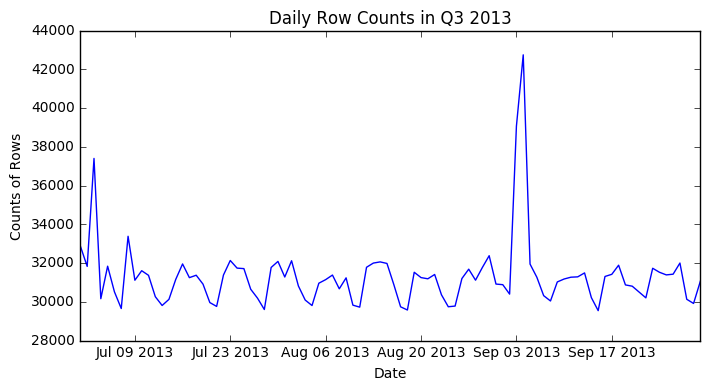

In [35]:
x = list(map(lambda x:x[0], my_2013Q3_row))
y = list(map(lambda x:x[1], my_2013Q3_row))
data = pd.DataFrame(y,x)

plt.figure(figsize=(8,4))
plt.plot(data[0])
plt.title("Daily Row Counts in Q3 2013")
plt.ylabel("Counts of Rows")
plt.xlabel("Date")
plt.show()

<h3>Q2. Plot the daily total number of entries & exits across the system for Q3 2013.

In [36]:
my_2013Q3_count = list(map(lambda date: (date[0], \
                        sum(list(map(lambda x: x[1], date[1])))), my_2013Q3_data))

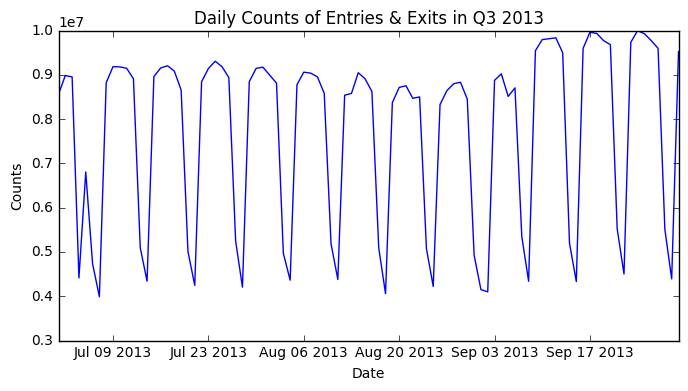

In [37]:
x = list(map(lambda x:x[0], my_2013Q3_count))
y = list(map(lambda x:x[1], my_2013Q3_count))
data = pd.DataFrame(y,x)

plt.figure(figsize=(8,4))
plt.plot(data[0])
plt.title("Daily Counts of Entries & Exits in Q3 2013")
plt.ylabel("Counts")
plt.xlabel("Date")
plt.show()

<h3>Q3. Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.

In [38]:
my_2013Q3_station_data = list(filter(lambda date: (date[0]>=date_2013_Q3[0])\
                             and(date[0]<=date_2013_Q3[-1]),my_2013_station_data))

my_2013Q3_PENN_count = list(map(lambda date:( date[0],\
                list(map(lambda y: sum(y[1]),\
                filter(lambda x: x[0]=='34 ST-PENN STA', date[1])))[0]), my_2013Q3_station_data))

date_2013M7 = date_2013_Q3[0:31]
date_2013M8 = date_2013_Q3[31:62]
date_2013M9 = date_2013_Q3[62:]

my_2013M7_PENN = list(map(lambda y: y[1], filter(lambda x: x[0] \
                                                 in date_2013M7, my_2013Q3_PENN_count)))
my_2013M8_PENN = list(map(lambda y: y[1], filter(lambda x: x[0] \
                                                 in date_2013M8, my_2013Q3_PENN_count)))
my_2013M9_PENN = list(map(lambda y: y[1], filter(lambda x: x[0] \
                                                 in date_2013M9, my_2013Q3_PENN_count)))

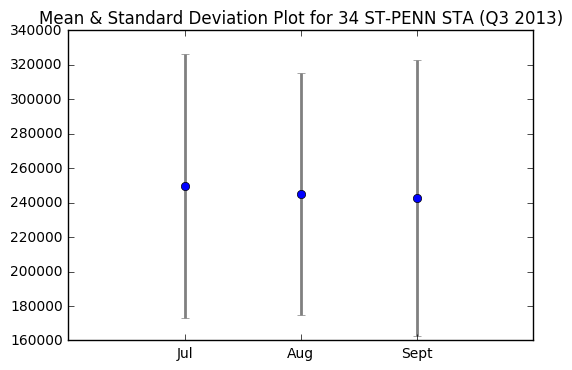

In [39]:
x = np.array(list(zip(my_2013M7_PENN, my_2013M8_PENN, my_2013M9_PENN)))

mins = x.min(0)
maxes = x.max(0)
means = x.mean(0)
std = x.std(0)

pct_25 = np.percentile(x, 25, axis=0)
pct_50= np.percentile(x, 50, axis=0)
pct_75 = np.percentile(x, 75, axis=0)

plt.errorbar(np.arange(3), means, std, fmt='ob',ecolor='gray', lw=2)
plt.title('Mean & Standard Deviation Plot for 34 ST-PENN STA (Q3 2013)')
plt.xlim(-1, 3)
plt.xticks(np.arange(3), ['Jul','Aug','Sept'])
plt.show()

<h3>Q4. Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.

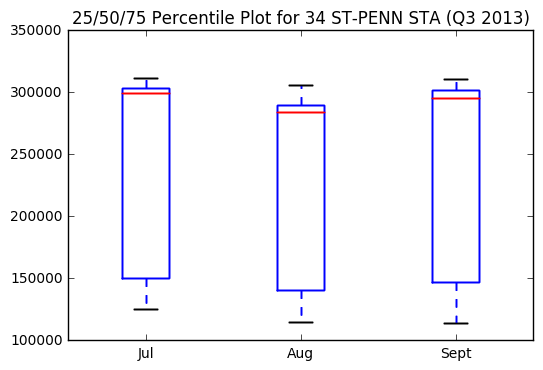

In [43]:
data=pylab.array([pylab.array(my_2013M7_PENN), pylab.array(my_2013M8_PENN), pylab.array(my_2013M9_PENN)])
pylab.boxplot(data)
pylab.title('25/50/75 Percentile Plot for 34 ST-PENN STA (Q3 2013)')
pylab.xticks([1,2,3], ['Jul','Aug','Sept'])
pylab.show()

<h3>Q5. Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q3 2013.

In [44]:
closed_2013Q3 = list(filter(lambda x:x[0] in date_2013_Q3, closed_2013))

closed_2013Q3_count = list(map(lambda x: (x[0], len(x[1])), closed_2013Q3))

not_full_2013Q3 = list(filter(lambda x:x[0] in date_2013_Q3, not_full_2013))

not_full_2013Q3_count = list(map(lambda x: (x[0], len(x[1])), not_full_2013Q3))

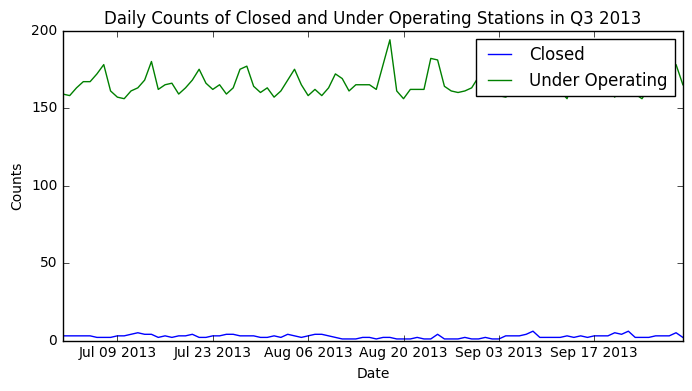

In [45]:
x = list(map(lambda x:x[0], closed_2013Q3_count))
y1 = list(map(lambda x:x[1], closed_2013Q3_count))
y2 = list(map(lambda x:x[1], not_full_2013Q3_count))
data1 = pd.DataFrame(y1,x)
data2 = pd.DataFrame(y2,x)

plt.figure(figsize=(8,4))
plt.plot(data1[0], label='Closed')
plt.plot(data2[0], label='Under Operating')
plt.title("Daily Counts of Closed and Under Operating Stations in Q3 2013")
plt.ylabel("Counts")
plt.xlabel("Date")
plt.legend()
plt.show()